In [12]:
bers = BersClient()
pts = PtsClient()
dats = DatsClient()

# get section metadata and data paths
macaque_dats_account = dats.get_account(name = 'mfishMERSCOPEmacaqueAtlas')
bers_spec = bers.get_specimen_by_lims2_id(lims2_id = barcode)
assert bers_spec.specimen_type.label == 'brain specimen section', f'not a LIMS2 Section specimen {bers_spec.name}'

qc_filt = pts_schema.MetadataFilterInput(
    type=pts_schema.DataTypeFilterInput(name=pts_schema.StringOperationFilterInput(eq="QCMetadata")))
request_filt = pts_schema.MetadataFilterInput(
    type=pts_schema.DataTypeFilterInput(name=pts_schema.StringOperationFilterInput(eq="MerscopeImagingRequestMetadata")))

spec_pts = pts.get_processes_by_biological_entities(bers_spec.id)
assert spec_pts.total_count == 1 and 'MerscopeCoverslipProcessing' in spec_pts.nodes[0].name, "not a MERSCOPE process"
merscope_expt = spec_pts.nodes[0]

for pts_output in merscope_expt.outputs: 
    dats_collection = dats.get_collection_by_id(account_id = macaque_dats_account.id, collection_id = pts_output.external_id)
    if dats_collection.type == 'File Bundle':
        spec_data_collection = dats_collection
        break
    
for asset in spec_data_collection.digital_assets:
    if asset.type == 'CSV' and 'detected_transcripts' in asset.name:
        assert len(asset.instances) == 1, f'more than one instance of asset {asset.name}'
        detected_transcripts_file = asset.instances[0].download_url
    if asset.type == 'Directory' and 'images' in asset.name:
        assert len(asset.instances) == 1, f'more than one instance of asset {asset.name}'
        images_path = asset.instances[0].download_url

qc_state = pts.get_process_metadata(process_id = merscope_expt.id, metadata_filter_input = qc_filt)[0].data['QC_State']
gene_panel = pts.get_process_metadata(process_id = merscope_expt.id, metadata_filter_input = request_filt)[0].data['GenePanel']

In [14]:
to_json(spec_data_collection)

{'id': '0140c680-e760-464e-916f-d83e3ded18d9',
 'createdAt': '2023-04-11T00:05:37.000121+00:00',
 'createdBy': '3d0b1a61-f9a0-46bb-95a1-67d6ab3f0d1a',
 'updatedAt': '2023-05-09T19:24:40.000433+00:00',
 'updatedBy': '3d0b1a61-f9a0-46bb-95a1-67d6ab3f0d1a',
 'name': 'mfishmerscopemacaqueatlas-1223197914',
 'description': 'Isilon Backfill',
 'type': 'File Bundle',
 'digitalAssets': [{'id': '18d619fa-ffe9-4734-9928-0fe7af1453f5',
   'createdAt': '2023-06-06T20:16:56.000100+00:00',
   'createdBy': '3d0b1a61-f9a0-46bb-95a1-67d6ab3f0d1a',
   'updatedAt': None,
   'updatedBy': None,
   'name': '/allen/programs/celltypes/production/mfish/mfishmerscopemacaqueatlas/1223197914/region_0/images/micron_to_mosaic_pixel_transform.csv',
   'type': 'CSV',
   'doi': None,
   'hash': '',
   'tags': ['1223197914'],
   'status': 'PENDING_REVIEW',
   'endOfLife': '2026-01-01T00:00:00+00:00',
   'use': None,
   'instances': [{'id': 'c9ef85da-e638-4e7d-a8ff-779d388080a2',
     'createdAt': '2023-06-06T20:16:56.0

Version 2 10/2/2023  
Pipeline to process MERSCOPE experiments as they come in.  
Want to organize sections with only relevant metadata from new services and have ability to attach analysis status.  
To do this, trying out a SpatialDataset Class that will hold this information and could be made into a dashboard.  

The pipeline has the following basic steps:  
1. Pull metadata from new services
2. Assessment of total counts and corrlation to bulkseq
3. Re-segmentation 
4. QC of cells and filtering out low quality ones
5. Creation of AnnData object for primary analysis
6. Mapping with scrattch-mapping
7. First stage analysis of mapping  

This notebook should be able to run by providing the MERSCOPE barcode 

In [1]:
barcode = 1223197914
broad_region = 'Basal Ganglia'

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pickle as pkl
from pathlib import Path, PurePath

from sawg import ScrattchMapping
from sawg import SpotTable

In [3]:
# import Allen Services

import allen_services_api.dats.schema.dats_schema as dats_schema
import allen_services_api.pts.schema.pts_schema as pts_schema
import allen_services_api.bers.schema.bers_schema as bers_schema
from allen_services_api.dats.client.dats_client import DatsClient
from allen_services_api.pts.client.pts_client import PtsClient
from allen_services_api.bers.client.bers_client import BersClient
from allen_services_api.core.json import to_json

# # Call the three clients before writing queries 
# bers = BersClient()
# pts = PtsClient()
# dats = DatsClient()

In [7]:
## Test out SpatialDataset Class structure

# globals that will go in a config file
merscope_save_path = "//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque"
mapping_dir = "/mapping"
segmentation_dir = "/segmentation"
macaque_merscope_lims_code = "mfishMERSCOPEmacaqueAtlas"
macaque_lims_code = "macaqueAtlas"
macaque_bulkseq_file = "//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/bulkseq/macaque/master_bulk_data.csv"

version = 1
class SpatialDataset:
    # wrapper class
    def __init__(self, barcode):
        self.barcode = barcode
        self.version = version
        
    @classmethod
    def load_from_barcode(cls, barcode: str, dataset_type: 'SpatialDataset'):
        if dataset_type == MERSCOPESection:
            path = os.path.join(merscope_save_path, barcode)
        # other config paths would be added here as they come about
        with open(path, 'rb') as file:
            dataset = pkl.load(file)
            file.close()
        return dataset
    
    def save_dataset(self, file_name: str='spatial_dataset'):
        file = open(os.path.join(self.save_path, file_name), 'wb')
        pkl.dump(self, file)
        file.close()
        
    def spatial_corr_to_bulk(self):
        if hasattr(self, 'detected_transcripts_cache') is False:
            self.detected_transcripts_cache = Path.joinpath(self.save_path, 'detected_transcripts.npz')
        spot_table = SpotTable.load_merscope(self.detected_transcripts_file, self.detected_transcripts_cache)
        
        genes, total_counts = np.unique(spot_table.gene_names, return_counts=True)

        total_counts = pd.DataFrame({'gene': genes, 'spatial total counts': total_counts})
        total_counts.set_index('gene', inplace=True)
        
        bulk_data = pd.read_csv(macaque_bulkseq_file)
        bulk_data.set_index('Gene Name', inplace=True)
        if self.broad_region is not None and broad_region in bulk_data['Broad Region'].unique():
            bulk_data_region = bulk_data[bulk_data['Broad Region']==self.broad_region]
        else:
            print(f'Section Broad Region ({self.broad_region}) does not match any in bulk data reference ({bulk_data["Broad Region"].unique()}). \
                Using all reference bulk sequencing data for spatial correlation.')
            bulk_data_region = bulk_data
                  
        total_counts = total_counts.merge(bulk_data_region['FPKM'], left_index=True, right_index=True, how='inner')

        total_counts_corr = total_counts.corr()['spatial total counts']['FPKM']
        self.corr_to_bulk = total_counts_corr

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        spot_table[::1000].scatter_plot(ax[0])
        sns.scatterplot(data=total_counts, x='spatial total counts', y='FPKM', alpha=0.5, lw=0, ax=ax[1])
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].set_title(f'Pearson corr: {total_counts_corr:0.3f}')
        plt.tight_layout()

        fig.savefig(Path.joinpath(self.save_path, 'correlation_to_bulk.pdf'))
        
        self.save_dataset()
        
class MERSCOPESection(SpatialDataset):

    pts_qc_filt = pts_schema.MetadataFilterInput(type=pts_schema.DataTypeFilterInput(
                name=pts_schema.StringOperationFilterInput(eq="QCMetadata")))
    pts_request_filt = pts_schema.MetadataFilterInput(type=pts_schema.DataTypeFilterInput(
                name=pts_schema.StringOperationFilterInput(eq="MerscopeImagingRequestMetadata")))

    def __init__(self, barcode):
        SpatialDataset.__init__(self, barcode)
        
        merscope_save_dir = Path(merscope_save_path)
        self.save_path = Path.joinpath(merscope_save_dir, str(barcode))
        if not Path.exists(self.save_path):
            Path.mkdir(self.save_path)
        
        self.get_section_metadata()
        self.get_section_data_paths()
        
        self.save_dataset()

    def get_section_metadata(self):
        bers = BersClient()
        pts = PtsClient()
        
        bers_spec = bers.get_specimen_by_lims2_id(lims2_id = self.barcode)
        assert bers_spec.specimen_type.label == 'brain specimen section', f'not a LIMS2 Section specimen {bers_spec.name}'
        
        self.bers_id = bers_spec.id
        self.species = bers_spec.species
        self.lims_specimen_name = bers_spec.name
#         self.roi  # this could come from multiple places, LIMS.structure, PTS_merscope_request_metadata_roi
#         self.hemisphere # may need to get this from slab parent if it is None
        self.plane_of_section =  bers_spec.external_data.plane_of_section.name
        
        spec_pts = pts.get_processes_by_biological_entities(bers_spec.id)
        assert spec_pts.total_count == 1 and 'MerscopeCoverslipProcessing' in spec_pts.nodes[0].name, "not a MERSCOPE process"
        merscope_expt = spec_pts.nodes[0]
        
        self.qc_state = pts.get_process_metadata(process_id = merscope_expt.id, 
                                                 metadata_filter_input = MERSCOPESection.pts_qc_filt)[0].data['QC_State']
        self.gene_panel = pts.get_process_metadata(process_id = merscope_expt.id, 
                                                   metadata_filter_input = MERSCOPESection.pts_request_filt)[0].data['GenePanel']
        self.merscope_expt_pts_id = merscope_expt.id
        
#         self.section_thickness # not sure where this comes from?
#         self.z_coord # this will probably require some math and grabbing of parent z_coord - nothing currently in BERS 
#         self.parent_z_coord
        
    def get_section_data_paths(self):
        platform = sys.platform # don't like this but need to edit the file names to be read by Windows
        #dats
        dats = DatsClient()
        pts = PtsClient()
        macaque_dats_account = dats.get_account(name = macaque_merscope_lims_code)
        
        merscope_expt = pts.get_process_by_id(self.merscope_expt_pts_id)
        for output in merscope_expt.outputs: 
            dats_collection = dats.get_collection_by_id(account_id = macaque_dats_account.id, collection_id = output.external_id)
            if dats_collection.type == 'File Bundle':
                spec_data_collection = dats_collection
                break

        for asset in spec_data_collection.digital_assets:
            if asset.type == 'CSV' and 'detected_transcripts' in asset.name:
                assert len(asset.instances) == 1, f'more than one instance of asset {asset.name}'
                self.detected_transcripts_file = asset.instances[0].download_url
                if platform.startswith('win'):
                    self.detected_transcripts_file = '/' + self.detected_transcripts_file
            if asset.type == 'Directory' and 'images' in asset.name:
                assert len(asset.instances) == 1, f'more than one instance of asset {asset.name}'
                self.images_path = asset.instances[0].download_url
                if platform.startswith('win'):
                    self.images_path = '/' + self.images_path
                
    

In [8]:
merscope_section = MERSCOPESection(barcode)
merscope_section.broad_region = broad_region
merscope_section.save_dataset()

In [ ]:
# TODO:
# - Do some checks on whether this barcode has been processed and if you want to re-process
# - Add some progress output info to aid in this

1. Load detected transcripts, calculate total counts, and correlate to bulk-seq. Look at some marker genes and zoom in for
sanity check

Loading from npz..


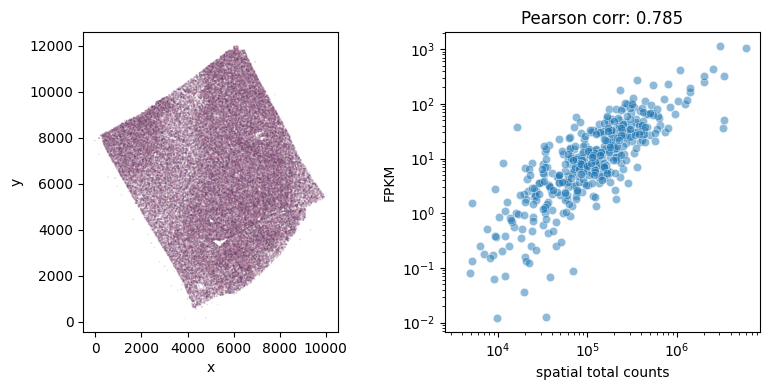

In [9]:
merscope_section.spatial_corr_to_bulk()

In [10]:
data_table = SpotTable.load_merscope(merscope_section.detected_transcripts_file, merscope_section.detected_transcripts_cache)

Loading from npz..


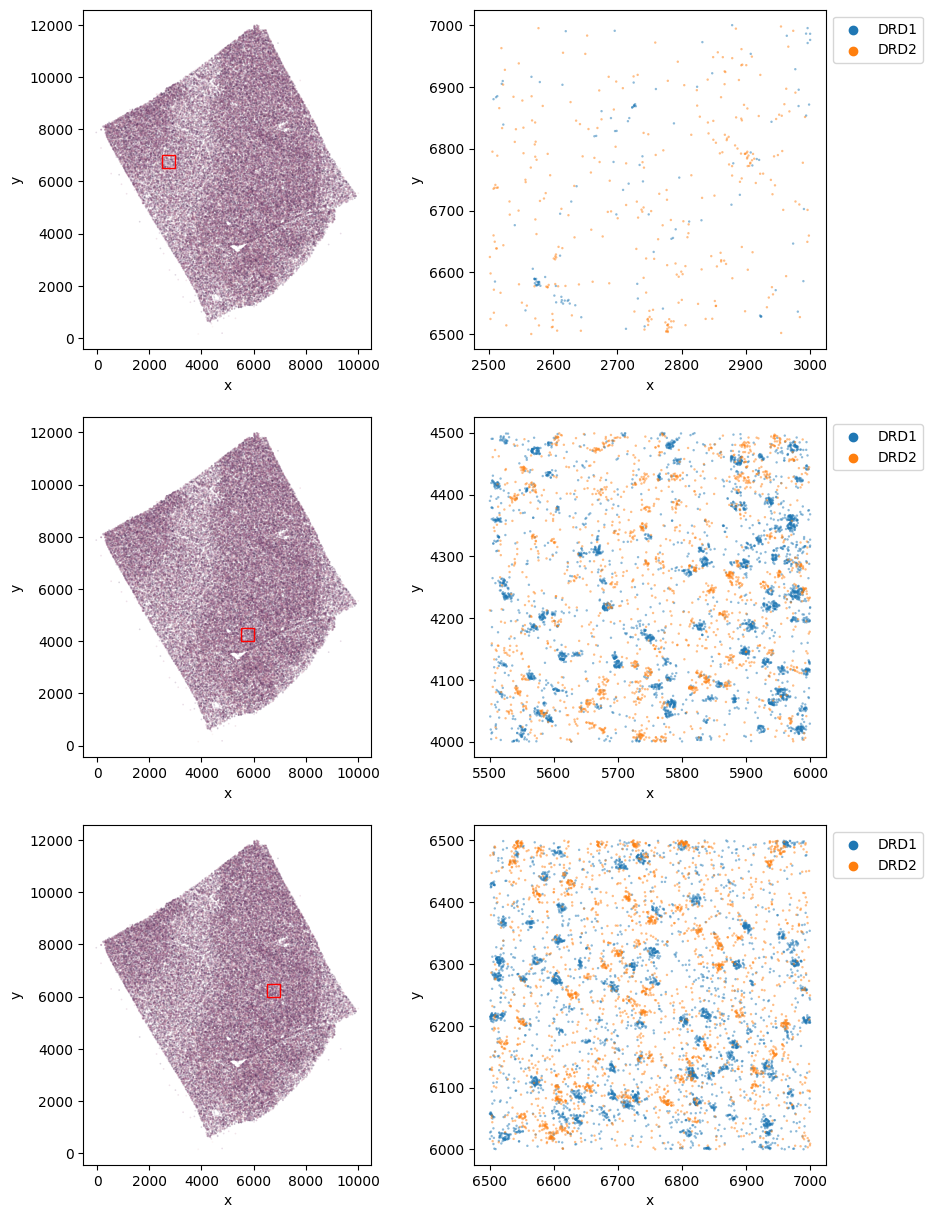

In [28]:
genes = ['DRD1', 'DRD2']  
subregions = [
    ((2500, 3000), (6500, 7000)),
    ((5500, 6000), (4000, 4500)),
    ((6500, 7000), (6000, 6500))
]

fig, ax = plt.subplots(len(subregions), 2, figsize=(10, len(subregions)*5))

genes_table = data_table.get_genes(genes)
for i, subregion in enumerate(subregions):
    data_table[::1000].scatter_plot(ax[i, 0])
    sub_table = genes_table.get_subregion(xlim=subregion[0], ylim=subregion[1])
    sub_table.plot_rect(ax[i, 0], 'r')
    df = sub_table.dataframe(cols=['x', 'y', 'gene_names'])
    sns.scatterplot(data=df, x='x', y='y', hue='gene_names', s=3, alpha=0.5, linewidth=0, ax=ax[i, 1], palette='tab10')
    ax[i, 1].legend(bbox_to_anchor=(1, 1))

2. Resegment cells by gene using Cellpose 
- Currently Vizgen has provided a docker image to run re-segmentation that runs on the HPC  
- For the time being, do this as a step outside of this notebook  
TODO:  
- Luke working on better segmentation with Cellpose and adding Baysor
- Incorporate this step better into pipeline

3. QC cells  
Current parameters for qc'ing include:  
- Volume
- Number of genes
- Number of spots/transcripts  
Other parameters and bounds on these can be altered and provided to `qc_cells`

In [9]:
def load_cellpose_segmentation(root_path):
    # root_path: where to look for the resegmented data
    # path to resegmented data
    cellpose_path = [dirpath for dirpath, _, _ in os.walk(root_path) if dirpath.endswith('cellpose_cyto2_nuclei')]
    if len(cellpose_path) != 1:
        print('Check that resegementation has been completed')
    else:
        cellpose_path = cellpose_path[0]

    cbg = pd.read_csv(cellpose_path + '/cellpose-cell-by-gene.csv')
    cbg.set_index('cell', inplace=True)
    cbg.index = cbg.index.astype('str')

    cbg_meta = pd.read_csv(cellpose_path + '/cellpose_metadata.csv')
    cbg_meta.rename(columns={'id': 'cell', 'center_x': 'x', 'center_y': 'y'}, inplace=True)
    cbg_meta.set_index('cell', inplace=True)
    cbg_meta.index = cbg_meta.index.astype('str')
    
    # make sure that the dataframes have the same cells and order
    cbg_meta = cbg_meta.reindex(cbg.index)
    assert cbg.index.equals(cbg_meta.index), 'Cell by gene table and cell by gene metadata indeces do not match'
    
    return cbg, cbg_meta
    
def qc_cells(cbg: pd.DataFrame, cbg_meta: pd.DataFrame, save_path,
                    qc_params: dict={'volume': [100, 3500], 'n_genes': [20, 420], 'n_transcripts': [100, 3500]}):
    
    gene_cols = [col for col in cbg.columns if not col.startswith('Blank')]
    cbg_meta['n_transcripts'] = cbg[gene_cols].sum(axis=1)
    cbg_meta['n_genes'] = cbg[cbg[gene_cols] != 0].count(axis=1)
    
    fig1, ax = plt.subplots(1, 3, figsize=(12,4))
    plt.tight_layout()

    qc_pass = None
    for i, (param, bounds) in enumerate(qc_params.items()):
        sns.violinplot(data=cbg_meta, y=param, cut=0, ax=ax[i])
        ax[i].axhline(bounds[0], ls='--', c='grey')
        ax[i].axhline(bounds[1], ls='--', c='grey')
        filt = cbg_meta[param].between(bounds[0], bounds[1])
        if qc_pass is None:
            qc_pass = filt
        else:
            qc_pass = qc_pass & filt
    
    plt.tight_layout()
    fig1.savefig(save_path + '/cell_qc_parameters.pdf')

    
    cbg_meta['qc'] = None
    cbg_meta['qc'].mask(qc_pass, other='pass', inplace=True)
    cbg_meta['qc'].mask(~qc_pass, other='fail', inplace=True)
    
    fig2, ax = plt.subplots(1, 2, figsize=(15, 8))
    sns.scatterplot(data=cbg_meta, x='x', y='y', alpha=0.4, s=2, color='grey', ax=ax[0])
    ax[0].set_title('All')
    sns.scatterplot(data=cbg_meta[cbg_meta['qc']=='pass'], x='x', y='y', alpha=0.4, s=2, color='grey', ax=ax[1])
    ax[1].set_title('QC: Pass')
    
    fig2.savefig(save_path + '/cell_qc_filter.pdf')
    
    return  cbg_meta, qc_params

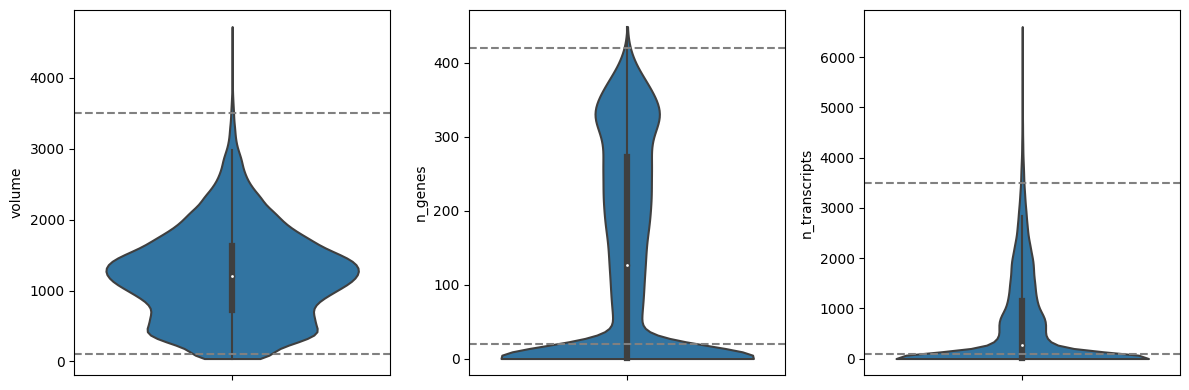

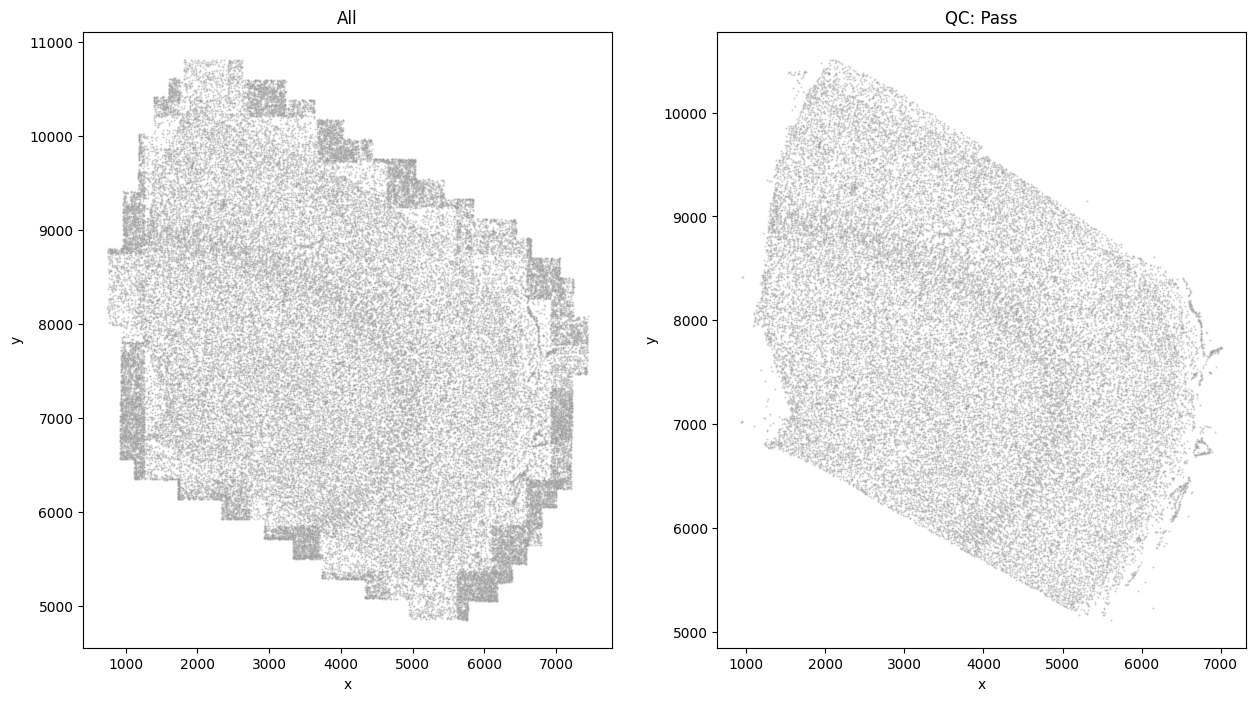

In [10]:
cbg, cbg_meta = load_cellpose_segmentation(out_path)
segmentation = 'cellpose'
cbg_meta, qc_params = qc_cells(cbg=cbg, cbg_meta=cbg_meta, save_path=out_path)

4. Generate AnnData object for spatial data  
- X = qc-pass cell x gene 
- obs = cell metadata dataframe
- obs_names = cell names (cbg index)
- var = gene metadata dataframe (gene or blank)
- var_names = gene names (cbg columns)
- uns = experiment metadata  
TODO:
- Currently metadata is being pulled from csv file, switch to LIMS when that is integrated

In [11]:
def get_exp_metadata(coverslip_meta_file: str, request_meta_file: str, barcode: str, meta_cols: list=None):
    coverslip_meta = pd.read_csv(coverslip_meta_file)
    request_meta = pd.read_csv(request_meta_file)
    spatial_exp_meta = coverslip_meta.merge(request_meta, left_on='MerscopeImagingRequestID', right_on='ID', suffixes=('_coverslip', '_request'))
    barcode_meta = spatial_exp_meta[spatial_exp_meta['Barcode']==barcode]
    cols=[
            'Specimen', 
            'ROI',
            'Species',
            'GenePanel',
        ]
    
    if meta_cols is not None:
        cols.extend(meta_cols)
        
    exp_meta = barcode_meta[cols].to_dict(orient='records')
    if len(exp_meta) != 1:
        print('Could not find experiment metadata')
        return None
    
    return exp_meta[0]

def make_spatial_anndata(cbg: pd.DataFrame, cbg_meta: pd.DataFrame, exp_meta: dict, cell_qc: str='pass'):
    from collections import OrderedDict
    
    cbg_filtered = cbg[cbg_meta['qc']==cell_qc]
    cbg_meta_filtered = cbg_meta[cbg_meta['qc']==cell_qc]

    gene_meta = pd.DataFrame(index=cbg_filtered.columns)
    gene_meta['probe_type'] = None
    gene_meta['probe_type'] = gene_meta.apply(lambda x: 'blank' if x.name.startswith('Blank') else 'gene', axis=1)

    ad_sp = anndata.AnnData(
        X = cbg_filtered,
        obs = cbg_meta_filtered,
        var = gene_meta,
        uns = OrderedDict(exp_meta),
    )
    print(ad_sp.uns)

    ad_sp.obs_names = cbg_filtered.index.astype('str')
    ad_sp.var_names = cbg_filtered.columns
    
    return ad_sp

In [12]:
exp_meta = get_exp_metadata(coverslip_meta_file, request_meta_file, '1223198166, 1223198444')
exp_meta.update({
    'segmentation': segmentation,
    'cell_qc_params': qc_params,
    'method': 'MERSCOPE',
    'barcode': barcode
})

ad_sp = make_spatial_anndata(cbg, cbg_meta, exp_meta)
ad_sp.write_h5ad(sp_anndata_file)

OverloadedDict, wrapping:
	OrderedDict([('Specimen', 'QM22.26.031.CX45'), ('ROI', 'M1 and MTG'), ('Species', 'Macaque'), ('GenePanel', 'VZG600'), ('segmentation', 'cellpose'), ('cell_qc_params', {'volume': [100, 3500], 'n_genes': [20, 420], 'n_transcripts': [100, 3500]}), ('method', 'MERSCOPE'), ('barcode', '1223198444')])
With overloaded keys:
	['neighbors'].


5. Map with Tangram
- Create TangramMapping object
- Set training genes
- Map at the cluster level and merge back up to subclass and class

In [13]:
def get_training_genes(gene_panel_name=None, training_genes=None):
    if type(training_genes) == list:
        return training_genes
    if gene_panel_name is not None:
        gene_panel = pd.read_csv(vzg_panel_path + '/' + gene_panel_name + '.csv', header=None)
        if gene_panel.shape[1] > 1:
            # assume that there are multiple gene sets within panel and first row are headers
            gene_panel.columns = gene_panel.iloc[0]
            gene_panel.drop(gene_panel.index[0], inplace=True)
            gene_panel.reset_index(inplace=True)
            if type(training_genes) == str:
                try:
                    tg_list = gene_panel[training_genes].dropna().tolist()
                except KeyError:
                    print(f'{training_genes} is not a column in {gene_panel_name}, returning all genes')
                    all_genes = gene_panel.values.tolist()
                    tg_list = [g for sublist in all_genes for g in sublist if type(g)==str]
        else:
            all_genes = gene_panel.values.tolist()
            tg_list = [g for sublist in all_genes for g in sublist if type(g)==str]
        return tg_list

In [14]:
tg_map = TangramMapping(
    sc_data=sc_anndata_file, 
    sp_data=sp_anndata_file, 
    meta={'MERSCOPE barcode': barcode,}
)

gene_panel_name = tg_map.ad_sp.uns['GenePanel']

training_genes_list = get_training_genes(gene_panel_name, training_genes)

In [15]:
tg_map.set_training_genes(training_genes_list, meta={'training_genes': training_genes})

starting with 150 training genes..


INFO:root:134 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:490 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [16]:
tg_map.mapping(cluster_label=mapping_level)
tg_map.save_mapping(save_path=out_path)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 134 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.526, KL reg: 0.278
Score: 0.843, KL reg: 0.001
Score: 0.849, KL reg: 0.001
Score: 0.851, KL reg: 0.001
Score: 0.851, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001


INFO:root:Saving results..


In [4]:
# reload mapping if present
tg_map = TangramMapping.load_from_timestamp(directory=out_path, timestamp='1674519360.130')
print(tg_map.meta)

{'MERSCOPE barcode': '1223198444', 'training_genes': 'mFISHtools', 'mode': 'clusters', 'cluster_label': 'cluster'}


6. Do some basic analysis and make some plots
- Mapping probability distributions
- Mapping scatter plots, cluster level grouped by neighborhood

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


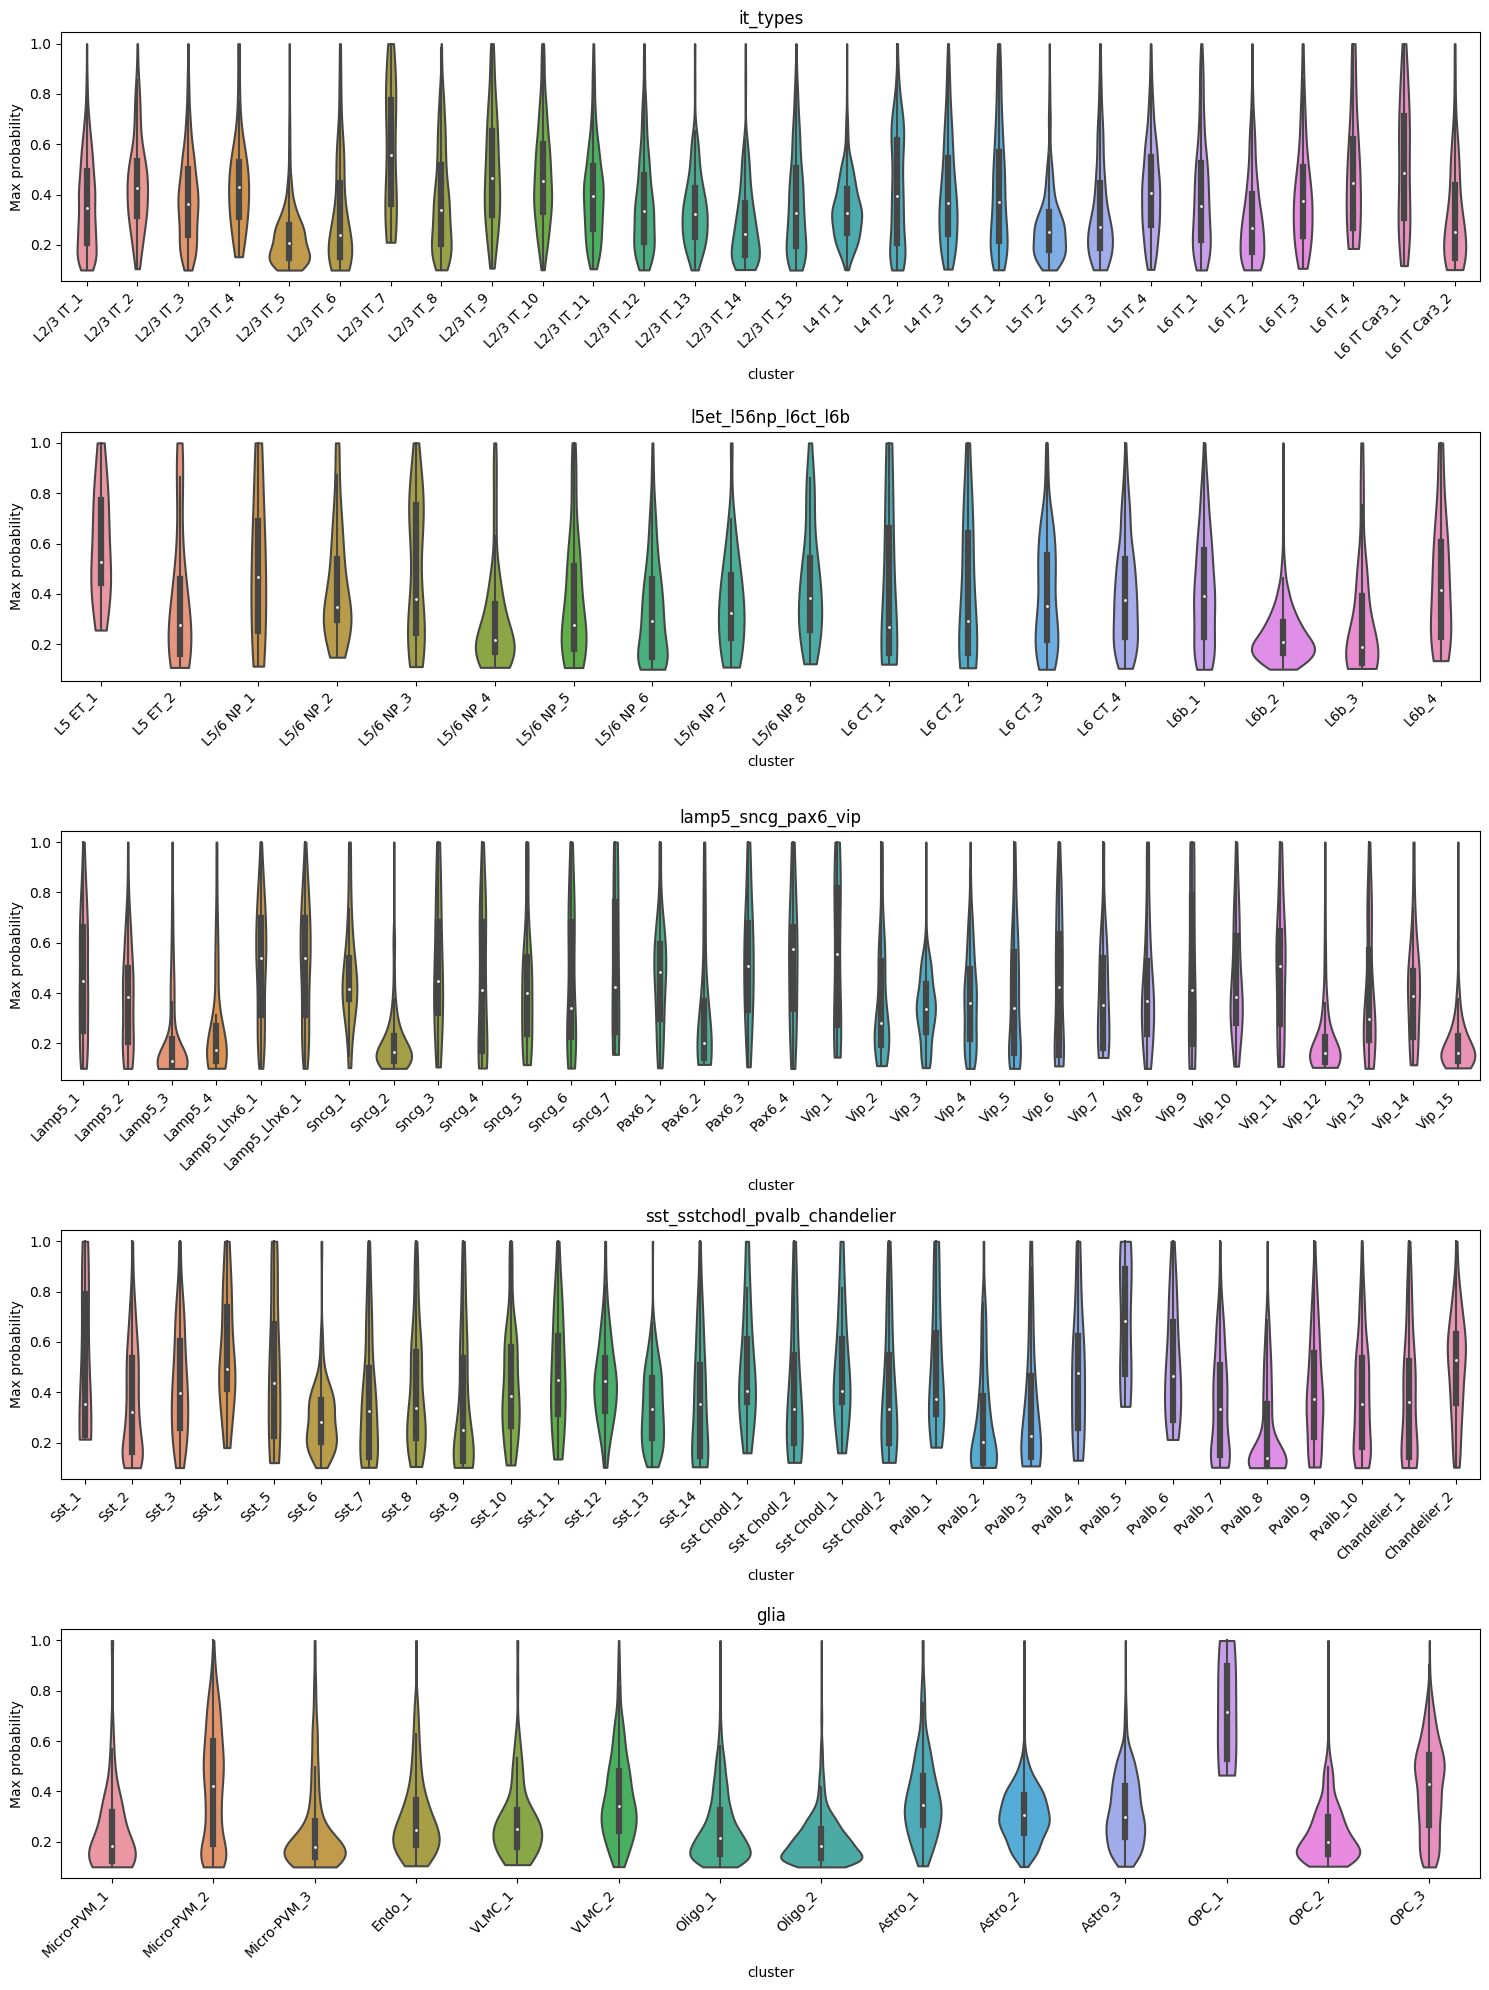

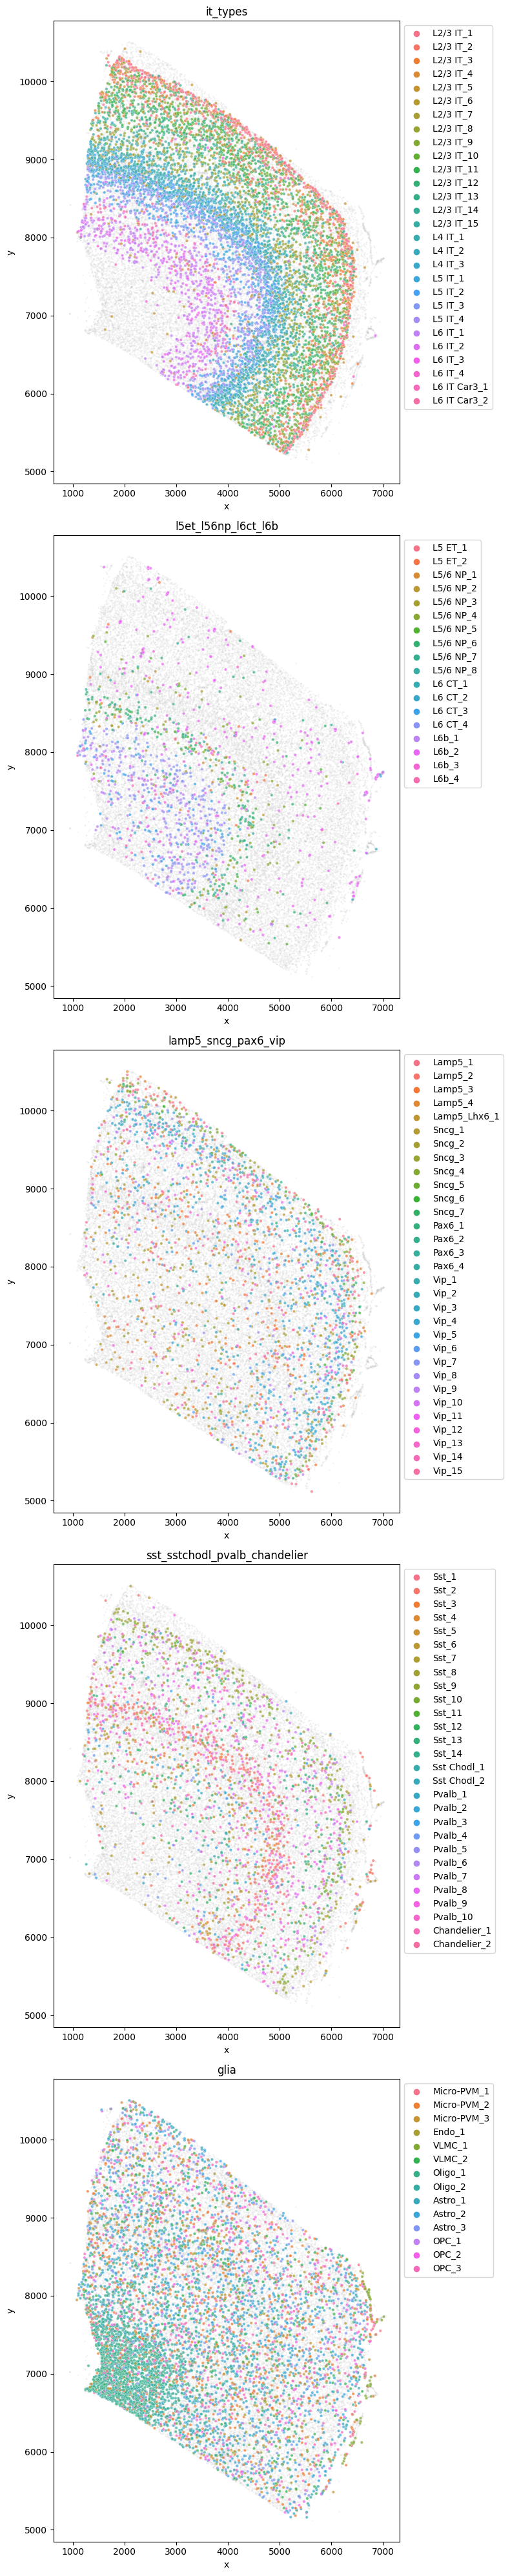

In [5]:
# discretize cell type mapping

tg_map.get_discrete_cell_mapping(threshold=mapping_threshold)

groups = {}
for cls in ['exc', 'inh', 'glia']:
    for neighborhood in tg_map.ordered_labels[cls]:
        groups[neighborhood] = [cl for clusters in list(tg_map.ordered_labels[cls][neighborhood].values()) for cl in clusters]

fig1 = tg_map.plot_discrete_mapping_probability(groups=groups)
fig2 = tg_map.plot_discrete_mapping(level=mapping_level, groups=groups)

fig1.savefig(out_path + '/celltype_mapping_score.pdf')
fig2.savefig(out_path + '/celltype_mapping_scatter.png', dpi=600)